In [ ]:
 # Uncomment and run this if you are running on Colab (remove only the "#", keep the "!").
# You can run it anyway, but it will do nothing if you have already installed all dependencies
# (and it will take some time to tell you it is not gonna do anything)


from google.colab import drive
drive.mount('/content/drive')
%cd "/content/drive/MyDrive/"
! git clone https://github.com/vischia/machine_learning_tutorial.git
%cd machine_learning_tutorial
!pwd
!ls
# ! pip install -r requirements.txt

Mounted at /content/drive
/content/drive/MyDrive
fatal: destination path 'machine_learning_tutorial' already exists and is not an empty directory.
/content/drive/MyDrive/machine_learning_tutorial
/content/drive/MyDrive/machine_learning_tutorial
base_nn_weights_1000.h5      model.png			   red_750.h5
base_nn_weights_500_1000.h5  README.md			   red_merged_condicionada.h5
base_nn_weights_500.h5	     red_1000_condicionada.h5	   red_merged.h5
base_nn_weights_750.h5	     red_1000.h5		   requirements_macos.txt
base_nn_weights.h5	     red_500_1000_condicionada.h5  requirements.txt
base_nn_weights_merged.h5    red_500_1000.h5		   train_hyp.ipynb
data			     red_500_condicionada.h5	   winequality-red.csv
dropout_nn_weights.h5	     red_500.h5			   winequality-white.csv
figs			     red_750_condicionada.h5


In [ ]:
!pip install livelossplot
!pip install shap

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 533.5/533.5 kB 6.6 MB/s eta 0:00:00


In [ ]:
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
import glob
import os
import re
import math
import socket
import json
import pickle
import gzip
import copy
import array
import numpy as np
import numpy.lib.recfunctions as recfunc

plt.style.use(['default'])

from scipy.optimize import newton
from scipy.stats import norm

import datetime
from timeit import default_timer as timer

from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.metrics import roc_curve, auc, accuracy_score
from sklearn.tree import export_graphviz
from sklearn.inspection import permutation_importance
try:
    # See #1137: this allows compatibility for scikit-learn >= 0.24
    from sklearn.utils import safe_indexing
except ImportError:
    from sklearn.utils import _safe_indexing

from livelossplot import PlotLossesKeras

from keras.losses import mean_squared_error, binary_crossentropy
from keras.models import Sequential, Model
from keras.layers import Input, Dense, Dropout, Concatenate
from keras.layers import Lambda, Activation
from keras.optimizers import SGD
from tensorflow.keras.optimizers.legacy import Adam # for macos
# from keras.optimizers import Adam # for non-macos
from keras.regularizers import l2
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import LeakyReLU

import keras
from keras import backend as K
import tensorflow as tf
import pandas as pd

import shap
shap.initjs()

In [ ]:
INPUT_FOLDER = './'
HAVE_GPU = True

Leemos los ficheros csv de GitHub y quitamos la columna masa de cada uno de ellos:

'data/not1000_750_train_medium.csv' ---> 750 MASS

'data/1000_train_medium.csv' ---> 1000 MASS

'data/not1000_train_medium.csv' ---> 500 MASS

# Nueva sección

Ahora creo un data set que sea una mezcla de los 3 data sets anteriores, y los barajo (shuffle) para evitar sesgos.

DATASET PARA MASAS 500 Y 1000 SIN 750

In [ ]:
def plot_rocs(scores_and_names, y,color = 'black',title=False):
    pack=[]
    AUC = []
    for s, n in scores_and_names:
        fpr, tpr, thresholds = roc_curve(y.ravel(), s)
        pack.append([n, fpr,tpr,thresholds])

    lw=2
    for n, fpr, tpr, thresholds in pack:
        plt.plot(fpr, tpr, lw=lw,color=color, label="%s (AUC = %0.2f)" % (n, auc(fpr, tpr)))
        AUC.append(auc(fpr, tpr))
    plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    if title == True:
      plt.title("Receiver Operating Characteristic curve")
    plt.legend(frameon=True,fontsize=8,loc="lower right")

    return np.round(AUC,decimals=2)

In [ ]:
#LEARNING RATE
def lr_scheduler(epoch):
    default_lr = 0.001
    drop = 0.9
    epochs_drop = 5.0
    lr = default_lr * math.pow(drop, math.floor(epoch/epochs_drop))
    #lr = default_lr * np.power(drop, min(1, np.floor((1 + epoch)/epochs_drop)))

    return lr


Creamos ahora una red neuronal para los datos de masa 500 y la entrenamos.

Red neuronal genérica

In [ ]:
class RedNeuronal():
  def __new__(self,train_set,test_set):
        self.x_train = train_set.loc[:, train_set.columns != 'label'].to_numpy()
        self.y_train = train_set.loc[:, train_set.columns == 'label'].to_numpy()

        self.x_test = test_set.loc[:, test_set.columns != 'label'].to_numpy()
        self.y_test = test_set.loc[:, test_set.columns == 'label'].to_numpy()

        kernel_initializer='glorot_uniform'
        n_inputs = self.x_train.shape[1]
        n_hidden_layers= 1
        adam_learning_rate = 0.0001
        batch_size = 128
        n_neurons = 10
        nn_model = Sequential()

        nn_model.add(Dense(n_neurons, input_dim=n_inputs, kernel_initializer=kernel_initializer))

        for i in range(n_hidden_layers):
            nn_model.add(Dense(n_neurons, activation='relu', kernel_initializer=kernel_initializer))

        nn_model.add(Dense(1, activation='sigmoid', kernel_initializer=kernel_initializer))

        optimizer = Adam(learning_rate=adam_learning_rate)
        nn_model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

        callbacks = []

        callbacks.append(keras.callbacks.LearningRateScheduler(lr_scheduler))

        return nn_model,self.x_train,self.y_train,self.x_test,self.y_test

In [ ]:
def Entrenamiento(modelo,x_train,y_train,x_test,y_test,epochs):
    start_time = timer()
    history = modelo.fit(x_train, y_train, batch_size=128, epochs=epochs,
            verbose=False, validation_data=(x_test, y_test))

    end_time = timer()
    training_time = datetime.timedelta(seconds=(end_time - start_time))

    print('Entrenamiento Finalizado con éxito -->',training_time,'segundos')

In [ ]:
def Histograma(modelo,test_set,train_set,texto,loc='center',xlabel=True,ylabel=True):
  grupo_label_1 = test_set.groupby('label').get_group(1)
  grupo_label_0 = test_set.groupby('label').get_group(0)

  grupo_label_train_1 = train_set.groupby('label').get_group(1)
  grupo_label_train_0 = train_set.groupby('label').get_group(0)

  x_test_1 = grupo_label_1.loc[:, grupo_label_1.columns != 'label'].to_numpy()
  x_test_0 = grupo_label_0.loc[:, grupo_label_0.columns != 'label'].to_numpy()

  x_train_1 = grupo_label_train_1.loc[:, grupo_label_train_1.columns != 'label'].to_numpy()
  x_train_0 = grupo_label_train_0.loc[:, grupo_label_train_0.columns != 'label'].to_numpy()

  plt.hist(modelo.predict(x_test_1),bins=18,ec='black',color='red',histtype='barstacked',alpha=0.7,label='signal (test)')
  plt.hist(modelo.predict(x_test_0),bins=18,ec='black',color='blue',histtype='barstacked',alpha=0.7,label='background(test)')

  plt.hist(modelo.predict(x_train_1),bins=18,ec='green',color='green',histtype='step',alpha=1,label='signal(train)')
  plt.hist(modelo.predict(x_train_0),bins=18,ec='brown',color='brown',histtype='step',alpha=1,label='background(train)')

  xmin, xmax, ymin, ymax = plt.axis()
  plt.legend(frameon=True,fontsize=8)

  xmin, xmax, ymin, ymax = plt.axis()
  x_pos = (xmin + xmax) / 2
  y_pos = (ymin + ymax) / 2
  ha, va = 'center', 'center'
  if xlabel == True:
    plt.xlabel('Frequency')
  if ylabel == True:
    plt.ylabel('Frequency')

  plt.xlabel('Event probability of being classified as signal',fontsize=9)
  plt.text(x_pos, y_pos, texto, ha=ha, va=va, bbox=dict(facecolor='white', edgecolor='black', boxstyle='round'))

Primero creamos los datasets quitándole la columna asociada a la masa

In [ ]:
#500 GeV masa
train_set_500 = pd.read_csv('data/not1000_train_medium.csv', index_col=False)
test_set_500 = pd.read_csv('data/not1000_test_medium.csv', index_col=False)

if 'mass' in train_set_500.columns:
    train_set_500=train_set_500.drop(['mass'], axis=1)
    test_set_500=test_set_500.drop(['mass'], axis=1)

In [ ]:
#750 GeV masa
train_set_750 = pd.read_csv('data/not1000_750_train_medium.csv', index_col=False)
test_set_750 = pd.read_csv('data/not1000_750_test_medium.csv', index_col=False)

if 'mass' in train_set_750.columns:
    train_set_750 = train_set_750.drop(['mass'], axis=1)
    test_set_750 = test_set_750.drop(['mass'], axis=1)

In [ ]:
#1000 GeV masa
train_set_1000 = pd.read_csv('data/1000_train_medium.csv', index_col=False)
test_set_1000 = pd.read_csv('data/1000_test_medium.csv', index_col=False)

In [ ]:
#500,750,1000 GeV masa
train_set_merged = pd.concat([train_set_500, train_set_750, train_set_1000], ignore_index=True)
train_set_merged_shuffled = train_set_merged.sample(frac=1)

test_set_merged = pd.concat([test_set_500, test_set_750, test_set_1000], ignore_index=True)
test_set_merged_shuffled = test_set_merged.sample(frac=1)

In [ ]:
#500,1000 GeV masa
train_set_500_1000 = pd.concat([train_set_500, train_set_1000], ignore_index=True)
train_set_500_1000_shuffled = train_set_500_1000.sample(frac=1)

test_set_500_1000 = pd.concat([test_set_500,test_set_1000], ignore_index=True)
test_set_500_1000_shuffled = test_set_500_1000.sample(frac=1)

Entrenamos las redes

In [ ]:
red_500, x_train_500, y_train_500, x_test_500, y_test_500 = RedNeuronal(train_set_500,test_set_500)
Entrenamiento(red_500,x_train_500,y_train_500,x_test_500,y_test_500,200)

Entrenamiento Finalizado con éxito --> 0:01:23.055069 segundos


In [ ]:
red_500.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 10)                290       
                                                                 
 dense_1 (Dense)             (None, 10)                110       
                                                                 
 dense_2 (Dense)             (None, 1)                 11        
                                                                 
Total params: 411 (1.61 KB)
Trainable params: 411 (1.61 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
red_750, x_train_750, y_train_750, x_test_750, y_test_750 = RedNeuronal(train_set_750,test_set_750)
Entrenamiento(red_750,x_train_750,y_train_750,x_test_750,y_test_750,200)

Entrenamiento Finalizado con éxito --> 0:01:22.433705 segundos


In [ ]:
red_1000, x_train_1000, y_train_1000, x_test_1000, y_test_1000 = RedNeuronal(train_set_1000,test_set_1000)
Entrenamiento(red_1000,x_train_1000,y_train_1000,x_test_1000,y_test_1000,200)

Entrenamiento Finalizado con éxito --> 0:00:56.378489 segundos


In [ ]:
#500,1000 GeV masa
train_set_500_1000 = pd.concat([train_set_500, train_set_1000], ignore_index=True)
train_set_500_1000_shuffled = train_set_500_1000.sample(frac=1)

test_set_500_1000 = pd.concat([test_set_500,test_set_1000], ignore_index=True)
test_set_500_1000_shuffled = test_set_500_1000.sample(frac=1)

train_set_500_1000_muestra = train_set_500_1000_shuffled.sample(n=10000)
test_set_500_1000_muestra = test_set_500_1000_shuffled.sample(n=10000)

In [ ]:
red_500_1000, x_train_500_1000, y_train_500_1000, x_test_500_1000, y_test_500_1000 = RedNeuronal(train_set_500_1000_muestra,test_set_500_1000_muestra)
Entrenamiento(red_500_1000,x_train_500_1000,y_train_500_1000,x_test_500_1000,y_test_500_1000,200)

Entrenamiento Finalizado con éxito --> 0:00:55.800298 segundos


In [ ]:
#500,750,1000 GeV masa
train_set_merged = pd.concat([train_set_500, train_set_750, train_set_1000], ignore_index=True)
train_set_merged_shuffled = train_set_merged.sample(frac=1)

test_set_merged = pd.concat([test_set_500, test_set_750, test_set_1000], ignore_index=True)
test_set_merged_shuffled = test_set_merged.sample(frac=1)

train_set_merged_muestra = train_set_merged_shuffled.sample(n=10000)
test_set_merged_muestra = test_set_merged_shuffled.sample(n=10000)

In [ ]:
red_merged, x_train_merged, y_train_merged, x_test_merged, y_test_merged =RedNeuronal(train_set_merged_muestra,test_set_merged_muestra)
Entrenamiento(red_merged,x_train_merged,y_train_merged,x_test_merged,y_test_merged,200)

Entrenamiento Finalizado con éxito --> 0:01:22.676175 segundos


Ploteamos las curvas ROC y observamos su AUC correspondiente

In [ ]:
plt.figure()

AUC_500 = plot_rocs([[red_500.predict(x_test_500)[:,0], 'NN_500 (test)'  ]], y_test_500,'tab:blue')
AUC_750 = plot_rocs([[red_750.predict(x_test_750)[:,0], 'NN_750 (test)'  ]], y_test_750,'tab:blue')
AUC_1000 = plot_rocs([[red_1000.predict(x_test_1000)[:,0], 'NN_1000 (test)'  ]], y_test_1000,'tab:blue')

AUC_500_1000_500 = plot_rocs([[red_500_1000.predict(x_test_500)[:,0], 'NN_500_1000  (test_500)'  ]], y_test_500,'tab:blue')
AUC_500_1000_750 = plot_rocs([[red_500_1000.predict(x_test_750)[:,0], 'NN_500_1000  (test_750)'  ]], y_test_750,'tab:blue')
AUC_500_1000_1000 = plot_rocs([[red_500_1000.predict(x_test_1000)[:,0], 'NN_500_1000  (test_1000)'  ]], y_test_1000,'tab:blue')

AUC_merged_500 = plot_rocs([[red_merged.predict(x_test_500)[:,0], 'NN_merged  (test_500)'  ]], y_test_500,'tab:blue')
AUC_merged_750 = plot_rocs([[red_merged.predict(x_test_750)[:,0], 'NN_merged  (test_750)'  ]], y_test_750,'tab:blue')
AUC_merged_1000 = plot_rocs([[red_merged.predict(x_test_1000)[:,0], 'NN_merged  (test_1000)'  ]], y_test_1000,'tab:blue')

plt.close()

313/313 [==============================] - 0s 1ms/step


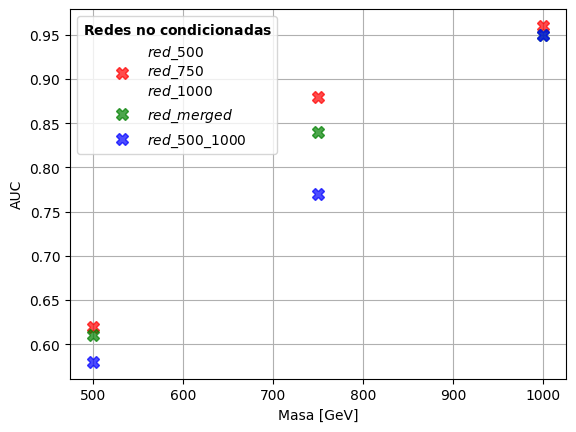

In [ ]:
plt.figure()
plt.xlabel('Masa [GeV]')
plt.ylabel('AUC')
t = 8.5
plt.plot(500,AUC_500,'X',color='red',markersize = t,alpha = 0.7)
plt.plot(500,AUC_500_1000_500,'X',markersize = t,color='blue',alpha = 0.7)
plt.plot(500,AUC_merged_500,'X',markersize = t,color='green',alpha = 0.7)
plt.plot(750,AUC_750,'X',markersize = t,color='red',alpha = 0.7)
plt.plot(750,AUC_merged_750,'X',markersize = t,color='green',alpha = 0.7)
plt.plot(750,AUC_500_1000_750,'X',markersize = t,color='blue',alpha = 0.7)
plt.plot(1000,AUC_1000,'X',markersize = t,color='red',alpha = 0.7,label='$red\_500$\n$red\_750$\n$red\_1000$')
plt.plot(1000,AUC_merged_1000,'X',markersize = t,color='green',alpha = 0.7,label='$red\_merged$')
plt.plot(1000,AUC_500_1000_1000,'X',markersize = t,color='blue',alpha = 0.7,label='$red\_500\_1000$')
plt.grid()
plt.legend(title='$\\bf{Redes \ no \ condicionadas}$')
plt.show()

313/313 [==============================] - 0s 1ms/step


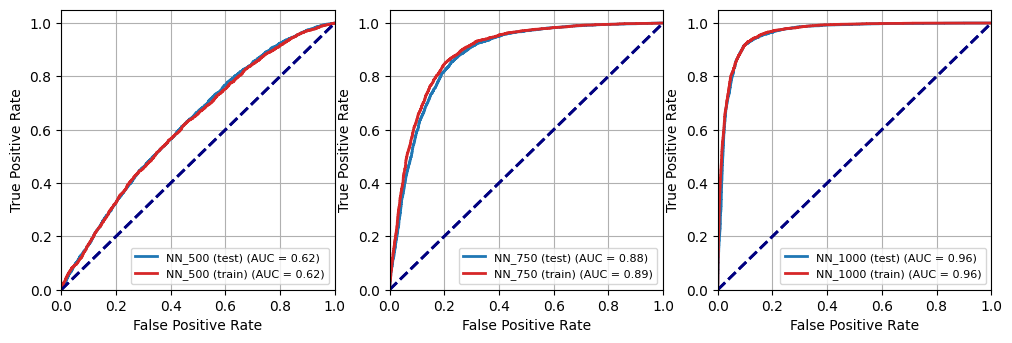

In [ ]:
plt.figure(figsize=(12,8))
plt.subplot(2,3,1)
plt.grid()
AUC_500_test = plot_rocs([[red_500.predict(x_test_500)[:,0], 'NN_500 (test)'  ]], y_test_500,'tab:blue')
AUC_500_train = plot_rocs([[red_500.predict(x_train_500)[:,0], 'NN_500 (train)'  ]], y_train_500,'tab:red')
plt.subplot(2,3,2)
plt.grid()
AUC_750_test = plot_rocs([[red_750.predict(x_test_750)[:,0], 'NN_750 (test)'  ]], y_test_750,'tab:blue')
AUC_750_train = plot_rocs([[red_750.predict(x_train_750)[:,0], 'NN_750 (train)'  ]], y_train_750,'tab:red')
plt.subplot(2,3,3)
plt.grid()
AUC_1000_test = plot_rocs([[red_1000.predict(x_test_1000)[:,0], 'NN_1000 (test)'  ]], y_test_1000,'tab:blue')
AUC_1000_train = plot_rocs([[red_1000.predict(x_train_1000)[:,0], 'NN_1000 (train)'  ]], y_train_1000,'tab:red')
plt.show()

156/156 [==============================] - 0s 3ms/step


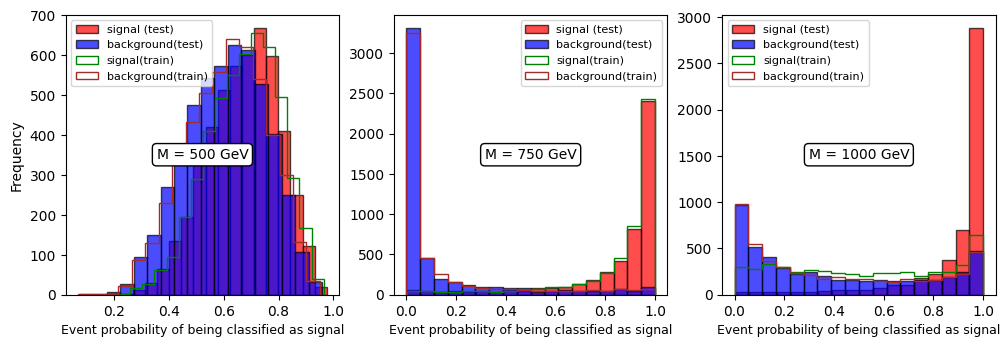

In [ ]:
plt.figure(figsize=(12,8))
plt.subplot(2,3,1)
Histograma(red_500,test_set_500,train_set_500,'M = 500 GeV',xlabel=False)
plt.subplot(2,3,2)
Histograma(red_1000,test_set_1000,train_set_1000,'M = 750 GeV',xlabel=False,ylabel=False)
plt.subplot(2,3,3)
Histograma(red_750,test_set_750,train_set_500,'M = 1000 GeV',xlabel=False,ylabel=False)


313/313 [==============================] - 0s 1ms/step


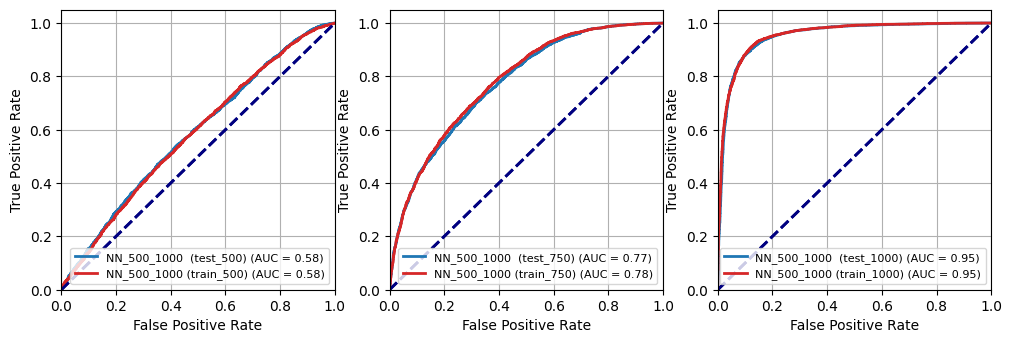

In [ ]:
plt.figure(figsize=(12,8))
plt.subplot(2,3,1)
plt.grid()
AUC_500_1000_test_500 = plot_rocs([[red_500_1000.predict(x_test_500)[:,0], 'NN_500_1000  (test_500)'  ]], y_test_500,'tab:blue')
AUC_500_1000_train_500 = plot_rocs([[red_500_1000.predict(x_train_500)[:,0], 'NN_500_1000 (train_500)'  ]], y_train_500,'tab:red')
plt.subplot(2,3,2)
plt.grid()
AUC_500_1000_test_750 = plot_rocs([[red_500_1000.predict(x_test_750)[:,0], 'NN_500_1000  (test_750)'  ]], y_test_750,'tab:blue')
AUC_500_1000_train_750 = plot_rocs([[red_500_1000.predict(x_train_750)[:,0], 'NN_500_1000 (train_750)'  ]], y_train_750,'tab:red')
plt.subplot(2,3,3)
plt.grid()
AUC_500_1000_test_1000 = plot_rocs([[red_500_1000.predict(x_test_1000)[:,0], 'NN_500_1000  (test_1000)'  ]], y_test_1000,'tab:blue')
AUC_500_1000_train_1000 = plot_rocs([[red_500_1000.predict(x_train_1000)[:,0], 'NN_500_1000 (train_1000)'  ]], y_train_1000,'tab:red')
plt.show()

157/157 [==============================] - 0s 2ms/step


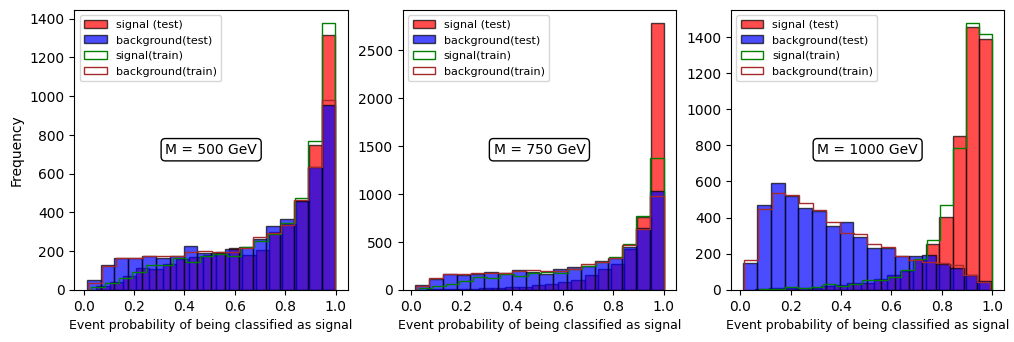

In [ ]:
plt.figure(figsize=(12,8))
plt.subplot(2,3,1)
Histograma(red_500_1000,test_set_500,train_set_500,'M = 500 GeV',xlabel=False)
plt.subplot(2,3,2)
Histograma(red_500_1000,test_set_750,train_set_500,'M = 750 GeV',xlabel=False,ylabel=False)
plt.subplot(2,3,3)
Histograma(red_500_1000,test_set_1000,train_set_1000,'M = 1000 GeV',xlabel=False,ylabel=False)

313/313 [==============================] - 0s 1ms/step


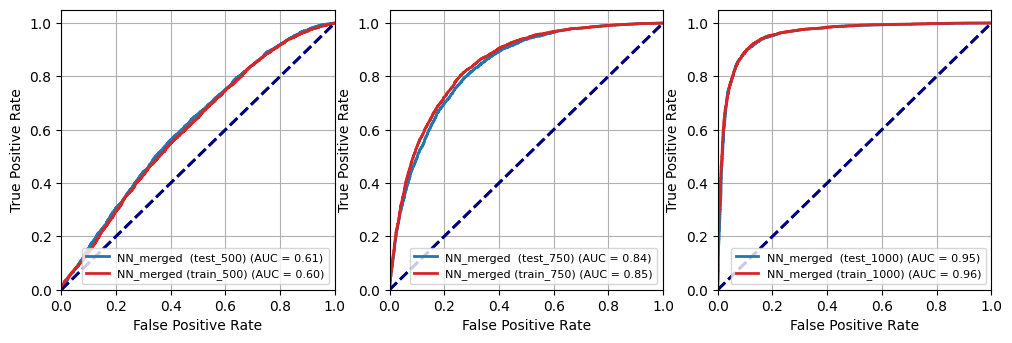

In [ ]:
plt.figure(figsize=(12,8))
plt.subplot(2,3,1)
plt.grid()
AUC_merged_test_500 = plot_rocs([[red_merged.predict(x_test_500)[:,0], 'NN_merged  (test_500)'  ]], y_test_500,'tab:blue')
AUC_merged_train_500 = plot_rocs([[red_merged.predict(x_train_500)[:,0], 'NN_merged (train_500)'  ]], y_train_500,'tab:red')
plt.subplot(2,3,2)
plt.grid()
AUC_merged_test_750 = plot_rocs([[red_merged.predict(x_test_750)[:,0], 'NN_merged  (test_750)'  ]], y_test_750,'tab:blue')
AUC_merged_train_750 = plot_rocs([[red_merged.predict(x_train_750)[:,0], 'NN_merged (train_750)'  ]], y_train_750,'tab:red')
plt.subplot(2,3,3)
plt.grid()
AUC_merged_test_1000 = plot_rocs([[red_merged.predict(x_test_1000)[:,0], 'NN_merged  (test_1000)'  ]], y_test_1000,'tab:blue')
AUC_merged_train_1000 = plot_rocs([[red_merged.predict(x_train_1000)[:,0], 'NN_merged (train_1000)'  ]], y_train_1000,'tab:red')
plt.show()

157/157 [==============================] - 0s 1ms/step


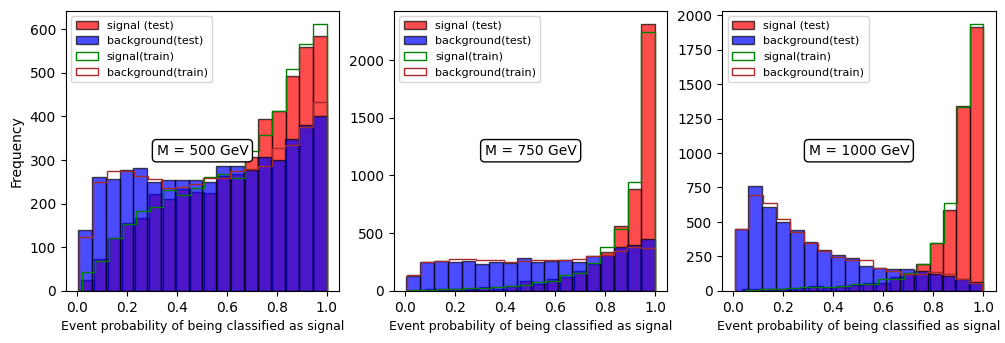

In [ ]:
plt.figure(figsize=(12,8))
plt.subplot(2,3,1)
Histograma(red_merged,test_set_500,train_set_500,'M = 500 GeV',xlabel=False,ylabel=True)
plt.subplot(2,3,2)
Histograma(red_merged,test_set_750,train_set_750,'M = 750 GeV',xlabel=False,ylabel=False)
plt.subplot(2,3,3)
Histograma(red_merged,test_set_1000,train_set_1000,'M = 1000 GeV',xlabel=False,ylabel=False)
plt.show()

In [ ]:
red_500.save('red_500.h5')
red_750.save('red_750.h5')
red_1000.save('red_1000.h5')
red_500_1000.save('red_500_1000.h5')
red_merged.save('red_merged.h5')

You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.


Añadimos la columna masa ahora para los mismos datasets, ESTO CONDICIONA LOS MODELOS OJO

In [ ]:
#500 GeV masa
train_set_500 = pd.read_csv('data/not1000_train_medium.csv', index_col=False)
test_set_500 = pd.read_csv('data/not1000_test_medium.csv', index_col=False)

In [ ]:
red_500, x_train_500, y_train_500, x_test_500, y_test_500 = RedNeuronal(train_set_500,test_set_500)
Entrenamiento(red_500,x_train_500,y_train_500,x_test_500,y_test_500,200)

Entrenamiento Finalizado con éxito --> 0:00:57.777432 segundos


In [ ]:
#750 GeV masa
train_set_750 = pd.read_csv('data/not1000_750_train_medium.csv', index_col=False)
test_set_750 = pd.read_csv('data/not1000_750_test_medium.csv', index_col=False)

In [ ]:
red_750, x_train_750, y_train_750, x_test_750, y_test_750 = RedNeuronal(train_set_750,test_set_750)
Entrenamiento(red_750,x_train_750,y_train_750,x_test_750,y_test_750,200)

Entrenamiento Finalizado con éxito --> 0:01:22.429399 segundos


In [ ]:
#1000 GeV masa
train_set_1000 = pd.read_csv('data/1000_train_medium.csv', index_col=False)
test_set_1000 = pd.read_csv('data/1000_test_medium.csv', index_col=False)
Masa1000 = np.zeros(10000,) + 1000
train_set_1000['mass'] = Masa1000
test_set_1000['mass'] = Masa1000

In [ ]:
red_1000, x_train_1000, y_train_1000, x_test_1000, y_test_1000 = RedNeuronal(train_set_1000,test_set_1000)
Entrenamiento(red_1000,x_train_1000,y_train_1000,x_test_1000,y_test_1000,200)

Entrenamiento Finalizado con éxito --> 0:01:22.425475 segundos


In [ ]:
#500,1000 GeV masa
train_set_500_1000 = pd.concat([train_set_500, train_set_1000], ignore_index=True)
train_set_500_1000_shuffled = train_set_500_1000.sample(frac=1)

test_set_500_1000 = pd.concat([test_set_500,test_set_1000], ignore_index=True)
test_set_500_1000_shuffled = test_set_500_1000.sample(frac=1)

train_set_500_1000_muestra = train_set_500_1000_shuffled.sample(n=10000)
test_set_500_1000_muestra = test_set_500_1000_shuffled.sample(n=10000)

In [ ]:
red_500_1000, x_train_500_1000, y_train_500_1000, x_test_500_1000, y_test_500_1000 = RedNeuronal(train_set_500_1000_muestra,test_set_500_1000_muestra)
Entrenamiento(red_500_1000,x_train_500_1000,y_train_500_1000,x_test_500_1000,y_test_500_1000,200)

Entrenamiento Finalizado con éxito --> 0:01:22.613908 segundos


In [ ]:
#500,750,1000 GeV masa
train_set_merged = pd.concat([train_set_500, train_set_750, train_set_1000], ignore_index=True)
train_set_merged_shuffled = train_set_merged.sample(frac=1)

test_set_merged = pd.concat([test_set_500, test_set_750, test_set_1000], ignore_index=True)
test_set_merged_shuffled = test_set_merged.sample(frac=1)

train_set_merged_muestra = train_set_merged_shuffled.sample(n=10000)
test_set_merged_muestra = test_set_merged_shuffled.sample(n=10000)

In [ ]:
red_merged, x_train_merged, y_train_merged, x_test_merged, y_test_merged =RedNeuronal(train_set_merged_muestra,test_set_merged_muestra)
Entrenamiento(red_merged,x_train_merged,y_train_merged,x_test_merged,y_test_merged,200)

Entrenamiento Finalizado con éxito --> 0:01:22.447290 segundos


GUARDAMOS LOS MODELOS (SE PUEDEN CARGAR DE LA SIGUIENTE FORMA : mymodel=load_model('myFirstNN.h5') #load our model


In [ ]:
plt.figure()

AUC_500 = plot_rocs([[red_500.predict(x_test_500)[:,0], 'NN_500 (test)'  ]], y_test_500,'tab:blue')
AUC_750 = plot_rocs([[red_750.predict(x_test_750)[:,0], 'NN_750 (test)'  ]], y_test_750,'tab:blue')
AUC_1000 = plot_rocs([[red_1000.predict(x_test_1000)[:,0], 'NN_1000 (test)'  ]], y_test_1000,'tab:blue')

AUC_500_1000_500 = plot_rocs([[red_500_1000.predict(x_test_500)[:,0], 'NN_500_1000  (test_500)'  ]], y_test_500,'tab:blue')
AUC_500_1000_750 = plot_rocs([[red_500_1000.predict(x_test_750)[:,0], 'NN_500_1000  (test_750)'  ]], y_test_750,'tab:blue')
AUC_500_1000_1000 = plot_rocs([[red_500_1000.predict(x_test_1000)[:,0], 'NN_500_1000  (test_1000)'  ]], y_test_1000,'tab:blue')

AUC_merged_500 = plot_rocs([[red_merged.predict(x_test_500)[:,0], 'NN_merged  (test_500)'  ]], y_test_500,'tab:blue')
AUC_merged_750 = plot_rocs([[red_merged.predict(x_test_750)[:,0], 'NN_merged  (test_750)'  ]], y_test_750,'tab:blue')
AUC_merged_1000 = plot_rocs([[red_merged.predict(x_test_1000)[:,0], 'NN_merged  (test_1000)'  ]], y_test_1000,'tab:blue')
plt.close()

313/313 [==============================] - 0s 1ms/step


In [ ]:
red_500.save('red_500_condicionada.h5')
red_750.save('red_750_condicionada.h5')
red_1000.save('red_1000_condicionada.h5')
red_500_1000.save('red_500_1000_condicionada.h5')
red_merged.save('red_merged_condicionada.h5')

You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.


313/313 [==============================] - 0s 1ms/step


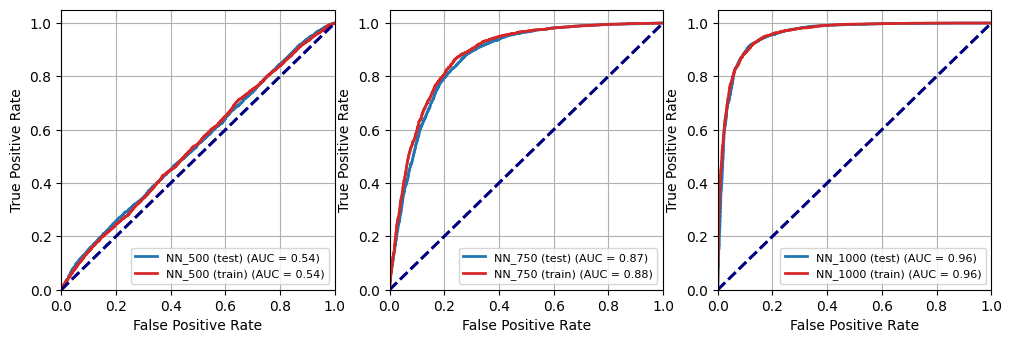

In [ ]:
plt.figure(figsize=(12,8))
plt.subplot(2,3,1)
plt.grid()
AUC_500_test = plot_rocs([[red_500.predict(x_test_500)[:,0], 'NN_500 (test)'  ]], y_test_500,'tab:blue')
AUC_500_train = plot_rocs([[red_500.predict(x_train_500)[:,0], 'NN_500 (train)'  ]], y_train_500,'tab:red')
plt.subplot(2,3,2)
plt.grid()
AUC_750_test = plot_rocs([[red_750.predict(x_test_750)[:,0], 'NN_750 (test)'  ]], y_test_750,'tab:blue')
AUC_750_train = plot_rocs([[red_750.predict(x_train_750)[:,0], 'NN_750 (train)'  ]], y_train_750,'tab:red')
plt.subplot(2,3,3)
plt.grid()
AUC_1000_test = plot_rocs([[red_1000.predict(x_test_1000)[:,0], 'NN_1000 (test)'  ]], y_test_1000,'tab:blue')
AUC_1000_train = plot_rocs([[red_1000.predict(x_train_1000)[:,0], 'NN_1000 (train)'  ]], y_train_1000,'tab:red')
plt.show()

156/156 [==============================] - 0s 1ms/step


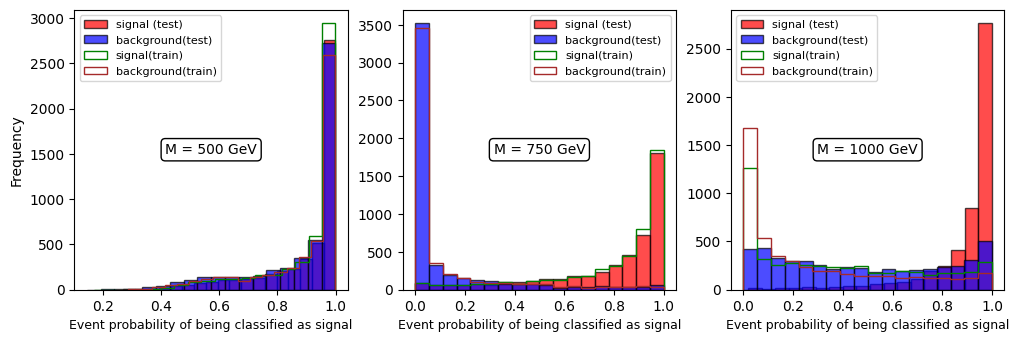

In [ ]:
plt.figure(figsize=(12,8))
plt.subplot(2,3,1)
Histograma(red_500,test_set_500,train_set_500,'M = 500 GeV',xlabel=False)
plt.subplot(2,3,2)
Histograma(red_1000,test_set_1000,train_set_1000,'M = 750 GeV',xlabel=False,ylabel=False)
plt.subplot(2,3,3)
Histograma(red_750,test_set_750,train_set_500,'M = 1000 GeV',xlabel=False,ylabel=False)

313/313 [==============================] - 0s 1ms/step


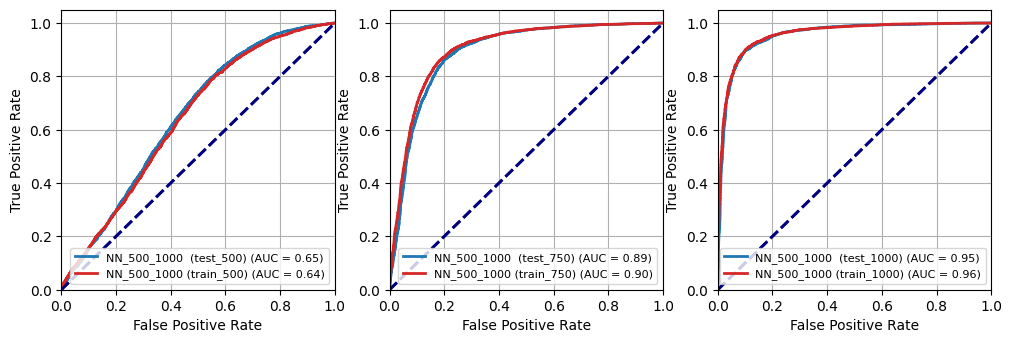

In [ ]:
plt.figure(figsize=(12,8))
plt.subplot(2,3,1)
plt.grid()
AUC_500_1000_test_500 = plot_rocs([[red_500_1000.predict(x_test_500)[:,0], 'NN_500_1000  (test_500)'  ]], y_test_500,'tab:blue')
AUC_500_1000_train_500 = plot_rocs([[red_500_1000.predict(x_train_500)[:,0], 'NN_500_1000 (train_500)'  ]], y_train_500,'tab:red')
plt.subplot(2,3,2)
plt.grid()
AUC_500_1000_test_750 = plot_rocs([[red_500_1000.predict(x_test_750)[:,0], 'NN_500_1000  (test_750)'  ]], y_test_750,'tab:blue')
AUC_500_1000_train_750 = plot_rocs([[red_500_1000.predict(x_train_750)[:,0], 'NN_500_1000 (train_750)'  ]], y_train_750,'tab:red')
plt.subplot(2,3,3)
plt.grid()
AUC_500_1000_test_1000 = plot_rocs([[red_500_1000.predict(x_test_1000)[:,0], 'NN_500_1000  (test_1000)'  ]], y_test_1000,'tab:blue')
AUC_500_1000_train_1000 = plot_rocs([[red_500_1000.predict(x_train_1000)[:,0], 'NN_500_1000 (train_1000)'  ]], y_train_1000,'tab:red')
plt.show()

157/157 [==============================] - 0s 1ms/step


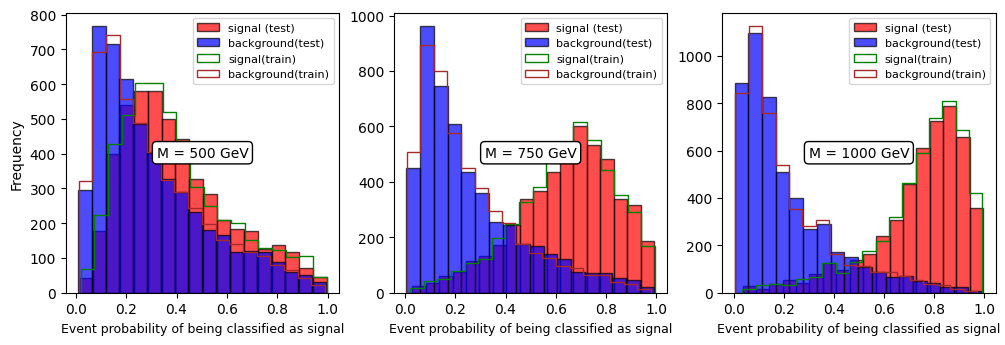

In [ ]:
plt.figure(figsize=(12,8))
plt.subplot(2,3,4)
Histograma(red_500_1000,test_set_500,train_set_500,'M = 500 GeV',xlabel=False,ylabel=True)
plt.subplot(2,3,5)
Histograma(red_500_1000,test_set_750,train_set_750,'M = 750 GeV',xlabel=False,ylabel=False)
plt.subplot(2,3,6)
Histograma(red_500_1000,test_set_1000,train_set_1000,'M = 1000 GeV',xlabel=False,ylabel=False)
plt.show()

313/313 [==============================] - 1s 2ms/step


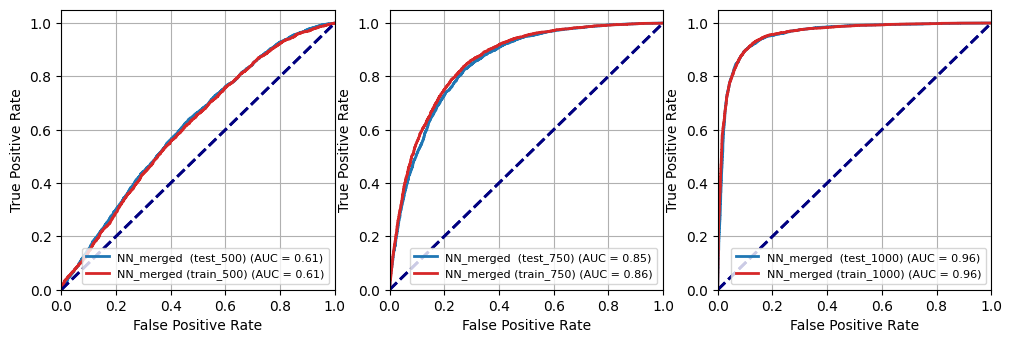

In [ ]:
plt.figure(figsize=(12,8))
plt.subplot(2,3,1)
plt.grid()
AUC_merged_test_500 = plot_rocs([[red_merged.predict(x_test_500)[:,0], 'NN_merged  (test_500)'  ]], y_test_500,'tab:blue')
AUC_merged_train_500 = plot_rocs([[red_merged.predict(x_train_500)[:,0], 'NN_merged (train_500)'  ]], y_train_500,'tab:red')
plt.subplot(2,3,2)
plt.grid()
AUC_merged_test_750 = plot_rocs([[red_merged.predict(x_test_750)[:,0], 'NN_merged  (test_750)'  ]], y_test_750,'tab:blue')
AUC_merged_train_750 = plot_rocs([[red_merged.predict(x_train_750)[:,0], 'NN_merged (train_750)'  ]], y_train_750,'tab:red')
plt.subplot(2,3,3)
plt.grid()
AUC_merged_test_1000 = plot_rocs([[red_merged.predict(x_test_1000)[:,0], 'NN_merged  (test_1000)'  ]], y_test_1000,'tab:blue')
AUC_merged_train_1000 = plot_rocs([[red_merged.predict(x_train_1000)[:,0], 'NN_merged (train_1000)'  ]], y_train_1000,'tab:red')
plt.show()

157/157 [==============================] - 0s 1ms/step


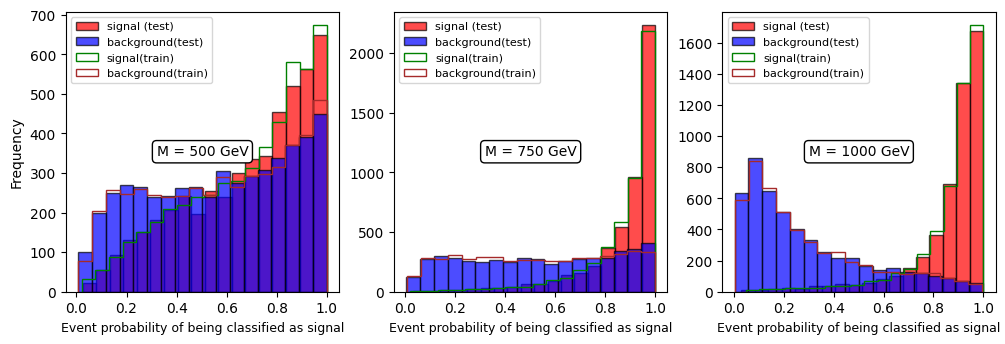

In [ ]:
plt.figure(figsize=(12,8))
plt.subplot(2,3,1)
Histograma(red_merged,test_set_500,train_set_500,'M = 500 GeV',xlabel=False,ylabel=True)
plt.subplot(2,3,2)
Histograma(red_merged,test_set_750,train_set_750,'M = 750 GeV',xlabel=False,ylabel=False)
plt.subplot(2,3,3)
Histograma(red_merged,test_set_1000,train_set_1000,'M = 1000 GeV',xlabel=False,ylabel=False)
plt.show()

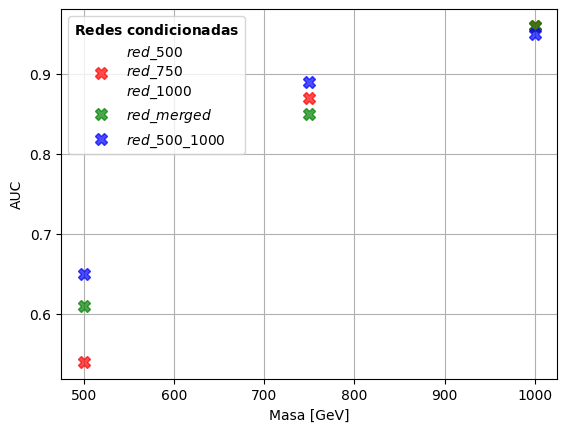

In [ ]:
plt.figure()
plt.xlabel('Masa [GeV]')
plt.ylabel('AUC')
t = 8.5
plt.plot(500,AUC_500,'X',color='red',markersize = t,alpha = 0.7)
plt.plot(500,AUC_500_1000_500,'X',markersize = t,color='blue',alpha = 0.7)
plt.plot(500,AUC_merged_500,'X',markersize = t,color='green',alpha = 0.7)
plt.plot(750,AUC_750,'X',markersize = t,color='red',alpha = 0.7)
plt.plot(750,AUC_merged_750,'X',markersize = t,color='green',alpha = 0.7)
plt.plot(750,AUC_500_1000_750,'X',markersize = t,color='blue',alpha = 0.7)
plt.plot(1000,AUC_1000,'X',markersize = t,color='red',alpha = 0.7,label='$red\_500$\n$red\_750$\n$red\_1000$')
plt.plot(1000,AUC_merged_1000,'X',markersize = t,color='green',alpha = 0.7,label='$red\_merged$')
plt.plot(1000,AUC_500_1000_1000,'X',markersize = t,color='blue',alpha = 0.7,label='$red\_500\_1000$')
plt.grid()
plt.legend(title='$\\bf{Redes \ condicionadas}$')
plt.show()